In [1]:
# import os
# os.environ['DATA_READER_VENDOR'] = 'tiingo'
%pylab inline
from requests import post
from app.analysis import Quote
def screen_funds(*filter, min_assets=1, max_expense=1):
    query = 'query screen($filter:[String!]!,$limit:[FundLimitOptionInput!]!){viewer{screenFunds(filterCategory:$filter,limit:$limit,sort:{type:FUND_TOTAL_ASSETS,direction:DESC},first:100){edges{node{symbol}}}}}'
    variables = {'filter':filter,'limit':[{'type':'FUND_TOTAL_ASSETS','min':min_assets*1000000000,'inclusive':True},{'type':'FUND_NET_EXPENSE_RATIO','max':max_expense,'inclusive':True}]}
    r = post('https://lens.m1finance.com/graphql', json={'query': query, 'variables': variables}).json()
    return [n['node']['symbol'] for n in r['data']['viewer']['screenFunds']['edges']]

Populating the interactive namespace from numpy and matplotlib


In [2]:
bonds = screen_funds('Bonds', 'Leveraged Debt', min_assets=.01, max_expense=1.2)
equities = screen_funds('Equities', 'Leveraged Equity', min_assets=.01, max_expense=1.2)
print(len(bonds), len(equities))
quote = Quote(bonds + equities, 64, 5)
print(f'from {quote.start.date()} to {quote.end.date()} - {len(quote.data.columns)}')

4 54
from 2019-04-18 to 2019-07-19 - 58


In [3]:
stats = quote.statistics()
stats = stats[stats['shrp'] > 0]
print(len(stats))
stats.sort_values('mean', ascending=False).head(20)

31


,len,mean,std,shrp,yield,drawdown
Symbols,,,,,,
JNUG,60,1.184954,2.670657,0.440722,113.180066,18.740160
NUGT,60,1.181553,2.323040,0.505207,107.633611,17.417822
GDXX,60,0.813722,1.550100,0.519828,66.273884,12.050224
BRZU,60,0.619251,2.029856,0.301161,43.327304,30.021138
RUSL,60,0.374445,1.071645,0.342006,24.389100,17.195892
TMF,60,0.335929,0.708914,0.462668,22.346173,9.129596
CURE,60,0.300768,1.071904,0.273188,19.911504,11.690278
UBT,60,0.235247,0.473749,0.479813,15.456254,6.193077
FAS,60,0.213781,0.986961,0.208564,12.047579,14.333784


evicted DRN 0.725 -0.198
evicted DFEN 0.701 -0.210
evicted RXL 0.793 -0.203
evicted RUSL 0.430 0.019
evicted BRZU 0.285 -0.001
evicted UPW 0.548 -0.076
evicted GDXX 0.393 -0.092
retry backlogs ['SPXL', 'UPRO', 'TQQQ', 'NUGT', 'TMF', 'UDOW', 'SSO', 'ROM', 'LBJ', 'URE', 'CURE', 'UXI', 'FINU', 'UYG', 'PPLC', 'UBT', 'TECL', 'DDM', 'QLD', 'JNUG', 'FAS', 'UCC'] at 0.805/-0.51 - 0.559
evicted URE 0.651 -0.128
evicted LBJ 0.383 0.016
evicted CURE 0.785 -0.208
evicted NUGT 0.396 -0.095
retry backlogs ['TQQQ', 'SPXL', 'UPRO', 'TMF', 'UDOW', 'SSO', 'ROM', 'FINU', 'UXI', 'UYG', 'PPLC', 'TECL', 'QLD', 'DDM', 'TYD', 'JNUG', 'FAS', 'UCC'] at 0.810/-0.52 - 0.532
evicted JNUG 0.376 -0.152
retry backlogs ['TQQQ', 'UYG', 'TMF', 'SPXL', 'UPRO', 'UDOW', 'SSO', 'UXI', 'PPLC', 'TYD', 'QLD', 'UBT', 'ROM', 'TECL', 'FINU', 'DDM', 'UCC'] at 0.815/-0.53 - 0.493
evicted UCC -0.507 -0.508
retry backlogs ['UYG', 'DDM', 'TMF', 'TQQQ', 'UPRO', 'SPXL', 'SSO', 'UXI', 'PPLC', 'QLD', 'ROM', 'FINU', 'TECL', 'UDOW', 'FAS', 

,count,mean,std,min,25%,50%,75%,max,shrp,yield,drawdown
Portfolio,60.0,0.160441,0.232240,-0.626440,0.013183,0.155095,0.366486,0.717349,0.656668,10.379450,3.086946
TYD,60.0,0.193577,0.336137,-0.842231,-0.025190,0.202601,0.402806,1.174379,0.552275,12.709820,4.135924
PPLC,60.0,0.062473,0.473948,-1.112493,-0.274617,0.060120,0.328381,1.359911,0.115069,3.606814,8.925526


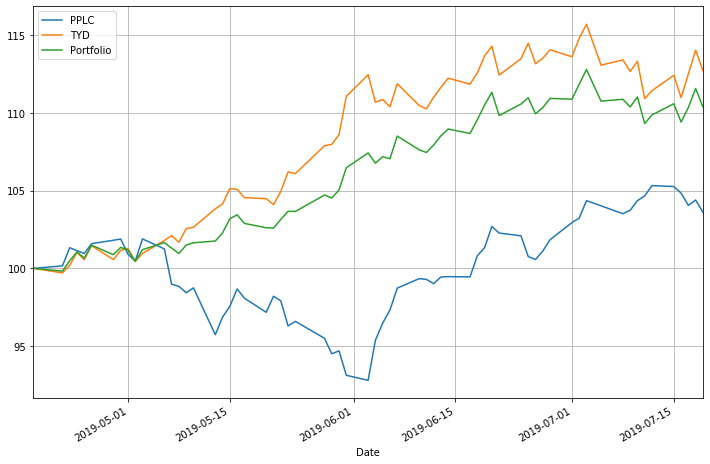

In [4]:
bounds = .16, .20
quote.setup_mask(stats.index)
sd = quote.optimize_portfolio(max_count=2, backlogs_pos_threshold=.8, _lambda=-1, bounds=bounds)
quote.setup_mask(['TYD', 'PPLC'])
sd.update(quote.optimize_portfolio(max_count=2, _lambda=-1, bounds=bounds))
quote.setup_mask({e for r in sd.values() for e in r})
sd.update(quote.optimize_portfolio(max_count=2, _lambda=-1, bounds=bounds))
for e in sd:
    print(e, sd[e])
_, ratio = sd.peekitem()
quote.setup_mask(ratio)
quote.graph(ratio)